# Code for launching White-box evasion attack on NN for the Mnist Dataset

## Generating the model

### Imports

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict
import scipy as sp
import sklearn
import sklearn.metrics
import itertools
import io

In [3]:
%load_ext tensorboard

### 1. Create input pipeline

#### Load dataset

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/danieldelijani/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

#### Build a training pipeline

In [6]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

#### Build an evaluation pipeline

In [7]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### 2. Create and train the model

Code for confusion martrix

In [10]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(ds_test)
    
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    test_labels = y = np.concatenate([y for x, y in ds_test], axis=0)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=[0,1,2,3,4,5,6,7,8,9])
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

Code for model

In [11]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/model_one"
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
    callbacks=[tensorboard_callback, cm_callback]
)

Epoch 1/6
469/469 [==============================] - 9s 9ms/step - loss: 0.3568 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.1905 - val_sparse_categorical_accuracy: 0.9443
Epoch 2/6
469/469 [==============================] - 3s 7ms/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9540 - val_loss: 0.1342 - val_sparse_categorical_accuracy: 0.9589
Epoch 3/6
469/469 [==============================] - 3s 5ms/step - loss: 0.1147 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.1087 - val_sparse_categorical_accuracy: 0.9674
Epoch 4/6
469/469 [==============================] - 3s 5ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.0937 - val_sparse_categorical_accuracy: 0.9711
Epoch 5/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0722 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.0821 - val_sparse_categorical_accuracy: 0.9749
Epoch 6/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0593 - sparse_categorical_accu

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Exploring the model

### What input nodes have the most impact?

In [13]:
i = 1
layer = model.layers[i]
weights = model.layers[i].weights[0]
bias = model.layers[i].weights[1]
print(layer.name, layer)
print('weights:', weights)
print('bias:', bias)

dense <keras.layers.core.dense.Dense object at 0x7fda8a750510>
weights: <tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
array([[ 0.04875562, -0.00820493,  0.02945039, ...,  0.02022272,
         0.03639601,  0.00201215],
       [-0.03095002,  0.05059651, -0.02891495, ...,  0.06038067,
        -0.05886814, -0.07256214],
       [ 0.04496192,  0.07928335, -0.00616924, ..., -0.07606561,
         0.06667996, -0.01771539],
       ...,
       [-0.01562378,  0.01042468, -0.02247919, ..., -0.04980258,
         0.04510731, -0.07249963],
       [-0.01323409, -0.02371042,  0.03507973, ...,  0.00151535,
         0.04758701,  0.04464307],
       [-0.00360978,  0.01461357, -0.02498238, ..., -0.01725758,
        -0.00053217, -0.07743933]], dtype=float32)>
bias: <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
array([ 0.0580643 ,  0.02225023,  0.04304934,  0.07412092,  0.05320349,
        0.01504719,  0.09585063,  0.05392756, -0.0590702 , -0.00531591,
        0.0025571

In [14]:
sum_of_weights = weights.numpy().sum(axis=1)
sum_of_weights.shape

(784,)

In [15]:
reshaped_weights = np.reshape(sum_of_weights, (28, 28))

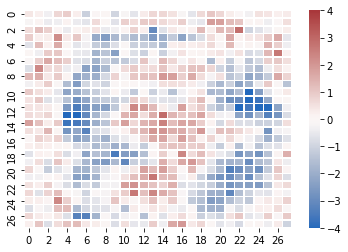

In [16]:
ax = sns.heatmap(reshaped_weights, linewidth=.5, cmap='vlag',vmin = -4, vmax=4)
plt.show()

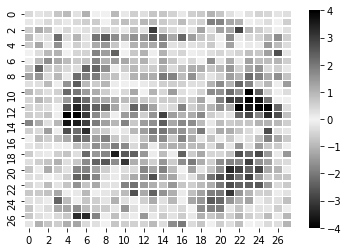

In [17]:
ax = sns.heatmap(reshaped_weights, linewidth=.5, cmap=sns.diverging_palette(0, 0, l=0, as_cmap=True),vmin = -4, vmax=4)
plt.show()

## An experiment with misclassification
1. Get all examples for one number
2. Separate misclassified and correctly classified examples
3. Get average image for misclassified and average image for correctly classified
4. Compare them -> take the difference?

### create data structure
[(image, class, prediction)]

In [18]:
images = np.concatenate([x for x, y in ds_test], axis=0)
classes = np.concatenate([y for x, y in ds_test], axis=0)
predictions = model.predict(ds_test).argmax(axis=-1)

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(classes, predictions)

0.975

In [20]:
images.shape, classes.shape, predictions.shape

((10000, 28, 28, 1), (10000,), (10000,))

### Create hashmap
{(class, is_correct) -> [image]}

In [21]:
from collections import defaultdict
hashmap = defaultdict(list)
for image, class_, prediction in zip(images, classes, predictions):
    is_correct = class_ == prediction
    key = (class_, is_correct)
    hashmap[key].append(image)

In [22]:
# hashmap = {}
# for image, class_, prediction in zip(images, classes, predictions):
#     is_correct = class_ == prediction
#     key = (class_, is_correct)
#     if key in hashmap:
#         hashmap[key] = np.append(hashmap[key], image) 
#     else:
#         hashmap[key] = []

In [23]:
len(hashmap.keys()) # Each class as well as mispredicted is represented!

20

In [24]:
np.array(hashmap[(0, True)]).shape

(966, 28, 28, 1)

### Create mean image hashmap
{(prediction, is_correct) -> mean_image}

In [25]:
mean_image_hashmap = {}

for key, images in hashmap.items():
    images_numpy = np.array(images)
    mean_image = images_numpy.mean(axis=0)
    mean_image_hashmap[key] = mean_image

### Display mean images

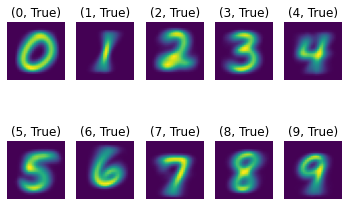

In [26]:
all_items = list(mean_image_hashmap.items())
for key, mean_image in all_items[:10]:
    plt.subplot(2,5,key[0]+1)
    plt.axis("off")
    plt.title(key)
    plt.imshow(mean_image.squeeze())

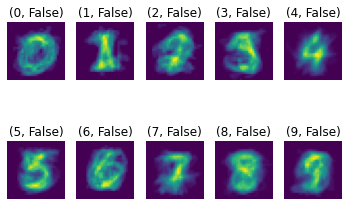

In [27]:
for key, mean_image in all_items[10:]:
    plt.subplot(2,5,key[0]+1)
    plt.axis("off")
    plt.title(key)
    plt.imshow(mean_image.squeeze())

### get some insight

#### get raw difference

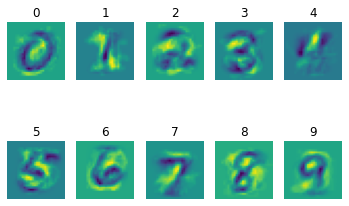

In [28]:
for class_ in range(10):
    im_true = mean_image_hashmap[(class_, True)]
    im_false = mean_image_hashmap[(class_, False)]
    im_difference = np.subtract(im_false, im_true)
    plt.subplot(2,5,class_+1)
    plt.axis("off")
    plt.title(class_)
    plt.imshow(im_difference.squeeze())

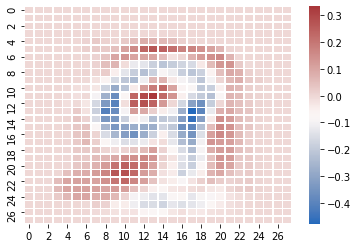

In [29]:
ax = sns.heatmap(im_difference.squeeze(), linewidth=.5, cmap='vlag')
plt.show()

#### setting negatives to zero and plot again
areas highlighted are where the false image has higher values

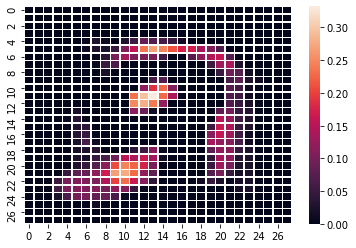

In [30]:
im_difference_pos = np.where(im_difference<0, 0, im_difference)

ax = sns.heatmap(im_difference_pos.squeeze(), linewidth=.5)
plt.show()

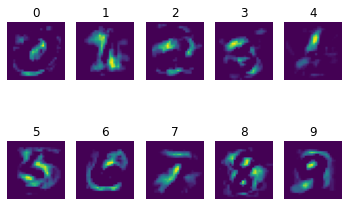

In [31]:
for class_ in range(10):
    im_true = mean_image_hashmap[(class_, True)]
    im_false = mean_image_hashmap[(class_, False)]
    im_difference = np.subtract(im_false, im_true)
    im_difference_pos = np.where(im_difference<0, 0, im_difference)
    
    plt.subplot(2,5,class_+1)
    plt.axis("off")
    plt.title(class_)
    plt.imshow(im_difference_pos.squeeze())

#### setting postive values to zero and plotting again
areas highlighted are where the true image has higher values

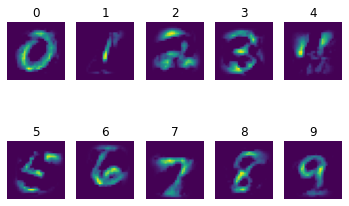

In [32]:
for class_ in range(10):
    im_true = mean_image_hashmap[(class_, True)]
    im_false = mean_image_hashmap[(class_, False)]
    im_difference = np.subtract(im_true, im_false)
    im_difference_pos = np.where(im_difference<0, 0, im_difference)
    
    plt.subplot(2,5,class_+1)
    plt.axis("off")
    plt.title(class_)
    plt.imshow(im_difference_pos.squeeze())

## A follow up experiment with misclassification
1. Get all examples that are classified as one number
2. Separate misclassified and correctly classified examples
3. Get average image for misclassified and average image for correctly classified
4. Compare them -> take the difference?

In [33]:
images = np.concatenate([x for x, y in ds_test], axis=0)
classes = np.concatenate([y for x, y in ds_test], axis=0)
predictions = model.predict(ds_test).argmax(axis=-1)

### Create hashmap
{(prediction, is_correct) -> [image]}

In [34]:
from collections import defaultdict
hashmap = defaultdict(list)
for image, class_, prediction in zip(images, classes, predictions):
    is_correct = class_ == prediction
    key = (prediction, is_correct)
    hashmap[key].append(image)

### Create mean image hashmap
{(prediction, is_correct) -> mean_image}

In [35]:
mean_image_hashmap = {}

for key, images in hashmap.items():
    images_numpy = np.array(images)
    mean_image = images_numpy.mean(axis=0)
    mean_image_hashmap[key] = mean_image

### Display mean images

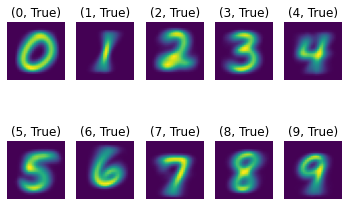

In [36]:
all_items = list(mean_image_hashmap.items())
for key, mean_image in all_items[:10]:
    plt.subplot(2,5,key[0]+1)
    plt.axis("off")
    plt.title(key)
    plt.imshow(mean_image.squeeze())

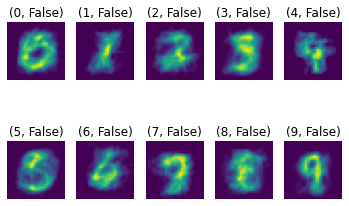

In [37]:
for key, mean_image in all_items[10:]:
    plt.subplot(2,5, key[0]+1)
    plt.axis("off")
    plt.title(key)
    plt.imshow(mean_image.squeeze())

### Get some insight

#### raw difference

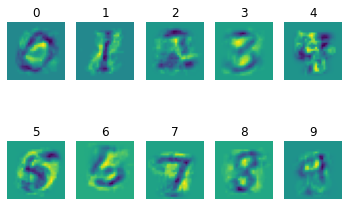

In [38]:
for class_ in range(10):
    im_true = mean_image_hashmap[(class_, True)]
    im_false = mean_image_hashmap[(class_, False)]
    im_difference = np.subtract(im_false, im_true)
    plt.subplot(2,5,class_+1)
    plt.axis("off")
    plt.title(class_)
    plt.imshow(im_difference.squeeze())

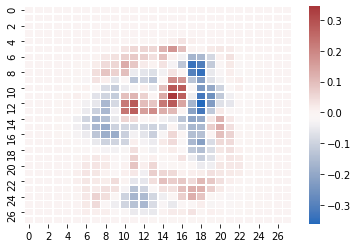

In [39]:
ax = sns.heatmap(im_difference.squeeze(), linewidth=.5, cmap='vlag')
plt.show()

#### highlight areas where true has higher values

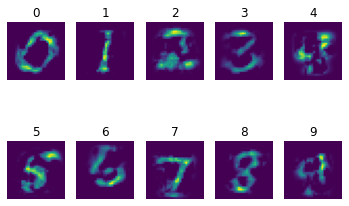

In [40]:
for prediction in range(10):
    im_true = mean_image_hashmap[(prediction, True)]
    im_false = mean_image_hashmap[(prediction, False)]
    im_difference = np.subtract(im_true, im_false)
    im_difference_pos = np.where(im_difference<0, 0, im_difference)
    
    plt.subplot(2,5,prediction+1)
    plt.axis("off")
    plt.title(prediction)
    plt.imshow(im_difference_pos.squeeze())

#### highlight areas where false has higher values

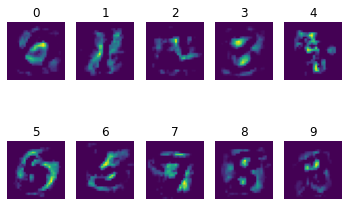

In [41]:
for prediction in range(10):
    im_true = mean_image_hashmap[(prediction, True)]
    im_false = mean_image_hashmap[(prediction, False)]
    im_difference = np.subtract(im_false, im_true)
    im_difference_pos = np.where(im_difference<0, 0, im_difference)
    
    plt.subplot(2,5,prediction+1)
    plt.axis("off")
    plt.title(prediction)
    plt.imshow(im_difference_pos.squeeze())

## CONFUSION MATRIX

In [165]:
from collections import defaultdict

def display_image(image):
    """
    displays an image
    """
    plt.imshow(image.squeeze())

class Confusion:
    def __init__(self, model, dataset):
        """
        initializer
        """
        self.model = model
        self.images = np.concatenate([x for x, y in dataset], axis=0)
        self.classes = np.concatenate([y for x, y in dataset], axis=0)
        self.predictions = model.predict(dataset).argmax(axis=-1)
        self.map = self.create_hashmap()
        
    def create_hashmap(self):
        """
        creates hashmap data structure:
        map[true_class][predicted_class] = list of images
        """
        hashmap = defaultdict(lambda: defaultdict(list))
        for image, class_, prediction in zip(self.images, self.classes, self.predictions):
            hashmap[class_][prediction].append(np.array(image))
        return hashmap
    
    def print_confusion(self):
        """
        print basic confusion matrix numbers
        """
        classes = list(set(self.classes))
        for true_class in classes:
            for predicted_class in classes:
                print(len(self.map[true_class][predicted_class]),end=" ")
            print()
            
    def confusion_images(self):
        """
        display the confusion matrix with images
        """
        """
        plt.subplot(2,5,prediction+1)
    plt.axis("off")
    plt.title(prediction)
    plt.imshow(im_difference_pos.squeeze())
        """
        classes = list(set(self.classes))
        i = 1
        for true_class in classes:
            for predicted_class in classes:
                plt.subplot(len(classes),len(classes),i)
                plt.axis("off")
#                 plt.title(f"{class_1},{class_2}")
                average_image = self.get_mean_image(true_class, predicted_class)
                if average_image == []:
                    average_image = np.zeros((28, 28))
                
                plt.imshow(average_image.squeeze())
                i += 1
                                
    
    def average_image(self, images):
        """
        returns the average image from a list of images
        """
        images_numpy = np.array(images)
        mean_image = images_numpy.mean(axis=0)
        return mean_image
        
    def get_classified(self, true_class, predicted_class):
        """
        returns the images of class true_class that are predicted as predicted_class
        """
        images = self.map[true_class][predicted_class]
#         if images == []:
#             return -1
# #             raise Exception(f'There are no images of class {true_class} that were classified as {predicted_class}')
        return images
    
    def get_mean_image(self, true_class, predicted_class):
        """
        returns the mean image for images classified of class true_class that are predicted as predicted_class
        """
        images = self.get_classified(true_class, predicted_class)
        if images == []:
            return []
        return self.average_image(images)
        
    def get_difference(self, image_1, image_2):
        """
        returns the difference between two images
        """
        return np.subtract(image_1, image_2)
    
    def negate_negatives(self, image):
        """
        returns image after negating negative values
        """
        return np.where(image<0, 0, image)
    
    def get_positive_difference(self, image_1, image_2):
        """
        returns the difference between two images with negatives set to zero
        """
        image_difference = self.get_difference(image_1, image_2)
        image_positive = self.negate_negatives(image_difference)
        return image_positive
        
    def get_difference_classes(self, true_class_1, predicted_class_1, true_class_2, predicted_class_2):
        """
        returns the difference of the mean images of true_class_1 predicted as predicted_class_1 minus
        images of true_class_2 predicted as predicted_class_2
        """
        image_1 = self.get_mean_image(true_class_1, predicted_class_1)
        image_2 = self.get_mean_image(true_class_2, predicted_class_2)
        
        diff = self.get_difference(image_1, image_2)
        return diff
        
        
    def get_positive_difference_classes(self, true_class_1, predicted_class_1, true_class_2, predicted_class_2):
        """
        returns the positive difference of images of true_class_1 predicted as predicted_class_1 minus
        images of true_class_1 predicted as predicted_class_1
        """
        image_1 = self.get_mean_image(true_class_1, predicted_class_1)
        image_2 = self.get_mean_image(true_class_2, predicted_class_2)
        
        diff = self.get_positive_difference(image_1, image_2)
        return diff
    
    def get_false_positives(self, predicted_class):
        """
        returns a list of images that are falsely identified as predicted_class
        """
        classes = list(set(self.classes))
        images = []
        
        for true_class in classes:
            if true_class == predicted_class:
                continue
            images.extend(self.map[true_class][predicted_class])
            
        return images
    
    def get_mean_false_positives(self, predicted_class):
        """
        returns the mean image of those that are falsely identified as predicted_class
        """
        images = self.get_false_positives(predicted_class)
        return self.average_image(images)
    
    def get_false_negatives(self, true_class):
        """
        returns a list of images of type true_class that are falsely predicted
        """
        classes = list(set(self.classes))
        images = []
        for predicted_class in classes:
            if true_class == predicted_class:
                continue
            images.extend(self.map[true_class][predicted_class])
            
        return images
    
    def get_mean_false_negatives(self, true_class):
        """
        returns the mean image of type true_class that are falsely predicted
        """
        images = self.get_false_negatives(true_class)
        return self.average_image(images)
    
    def get_true_positives(self, class_):
        """
        returns a list of images of type class_ that are correctly predicted
        """
        return self.map[class_][class_]
    
    def get_mean_true_positives(self, class_):
        """
        returns the mean image of type class_ that are correctly predicted
        """
        images = self.get_true_positives(class_)
        return self.average_image(images)
    

In [166]:
confusion = Confusion(model, ds_test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


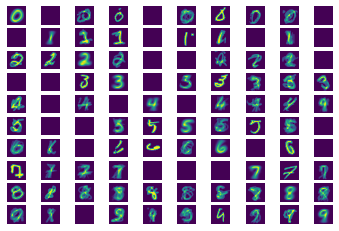

In [167]:
confusion.confusion_images()

In [168]:
confusion.print_confusion()

966 0 2 1 0 5 1 2 3 0 
0 1124 3 2 0 1 2 0 3 0 
2 2 1016 3 0 0 2 2 5 0 
0 0 1 991 0 6 1 5 3 3 
2 0 4 0 940 0 12 4 3 17 
2 0 0 8 1 869 6 1 5 0 
6 3 0 1 1 6 939 0 2 0 
1 5 11 6 0 0 0 999 1 5 
3 2 4 17 2 3 3 4 932 4 
4 6 0 7 4 5 1 6 2 974 


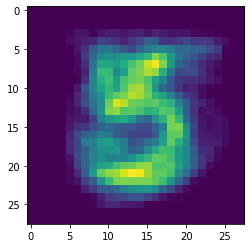

In [122]:
display_image(confusion.get_mean_false_negatives(5))

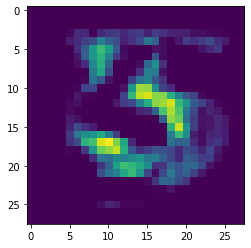

In [123]:
display_image(confusion.get_positive_difference(confusion.get_mean_false_negatives(5), confusion.get_mean_true_positives(5)))

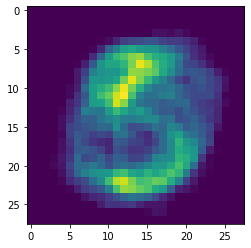

In [124]:
display_image(confusion.get_mean_false_positives(5))

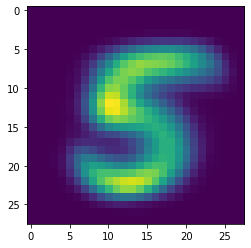

In [125]:
display_image(confusion.get_mean_true_positives(5))

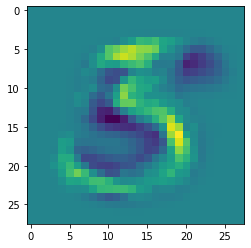

In [126]:
display_image(confusion.get_difference_classes(3, 5, 5, 5))

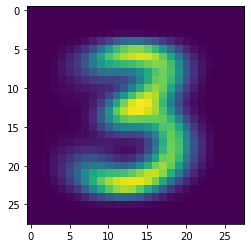

In [127]:
display_image(confusion.get_mean_image(3, 3))

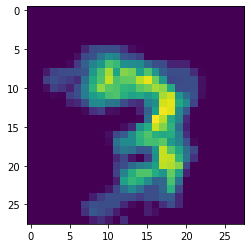

In [128]:
display_image(confusion.get_mean_image(3, 7))

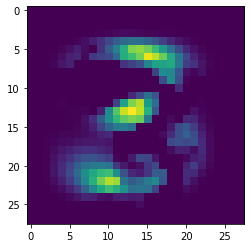

In [129]:
display_image(confusion.get_positive_difference_classes(3, 3, 3, 7))

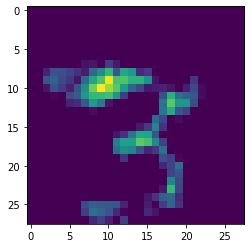

In [130]:
display_image(confusion.get_positive_difference_classes(3, 7, 3, 3))

## Visualization

In [ ]:
from mlxtend.plotting import plot_decision_regions

images = np.concatenate([x for x, y in ds_test], axis=0)
classes = np.concatenate([y for x, y in ds_test], axis=0)
predictions = model.predict(ds_test).argmax(axis=-1)

plot_decision_regions(images, classes, clf=model)# , legend=2

### Tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
# mnist = tf.keras.datasets.mnist

# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0

# def create_model():
#     return tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation='softmax')
#   ])

# model = create_model()
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.fit(x=x_train, 
#           y=y_train, 
#           epochs=5, 
#           validation_data=(x_test, y_test), 
#           callbacks=[tensorboard_callback])